<h1>Importing Libraries</h1>

In [16]:
"""
Code borrowed from: https://www.kaggle.com/thanaphatj/gender-classification-of-facial-images-cnn
"""

import os # accessing directory structure
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt # plotting
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from  IPython.display import display
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau 
#from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from tensorflow import test
import random

# Set Seed
np.random.seed(11)
tf.random.set_seed(11)
random.seed(11)

<h1>Data Preparation</h1>

In [18]:
for dirname, _, filenames in os.walk('C:/Books/Texas State Books/Gender_Classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
age_gender_data = pd.read_csv('C:/Books/Texas State Books/Gender_Classification/age_gender.csv')
age_gender_data.info()

C:/Books/Texas State Books/Gender_Classification\age_gender.csv
C:/Books/Texas State Books/Gender_Classification\age_gender.csv.zip
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [19]:
age_gender_data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


<AxesSubplot:xlabel='age', ylabel='count'>

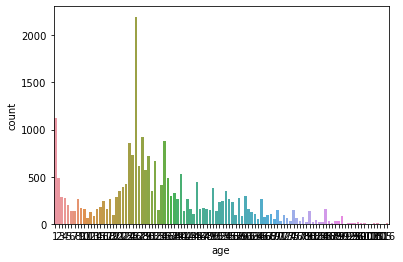

In [20]:
sns.countplot(x='age', data=age_gender_data) #age distribution

<AxesSubplot:xlabel='gender', ylabel='count'>

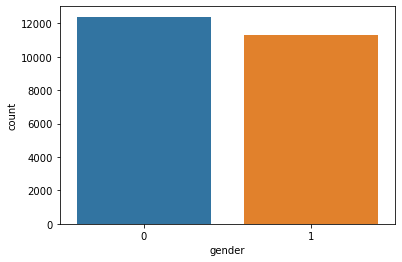

In [21]:
sns.countplot(x='gender', data=age_gender_data) #gender distribution

<h1>Data Preprocessing</h1>

<AxesSubplot:xlabel='age', ylabel='count'>

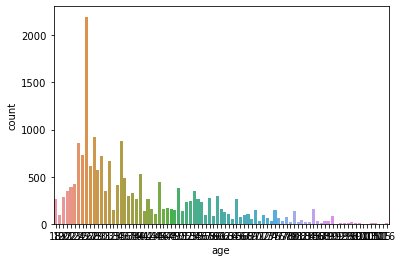

In [22]:
# Select only person who has age more than 18 
age_gender_data = age_gender_data[age_gender_data['age'] >= 18]
sns.countplot(x='age', data=age_gender_data) #age distribution

In [23]:
age_gender_data.reset_index(drop=True, inplace=True)
age_gender_data

,age,ethnicity,gender,img_name,pixels
0,100,0,0,20170112213500903.jpg.chip.jpg,203 185 139 163 176 184 186 175 175 156 159 13...
1,100,0,0,20170112215240346.jpg.chip.jpg,125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2,100,0,1,20170110183726390.jpg.chip.jpg,235 164 113 144 121 201 243 237 234 221 233 23...
3,100,0,1,20170112213001988.jpg.chip.jpg,82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4,100,0,1,20170112213303693.jpg.chip.jpg,70 72 94 149 154 166 175 169 172 161 176 187 2...
...,...,...,...,...,...
19467,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [24]:
age_gender_data.isnull().sum() # Check null data

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [26]:
# Input image configuration
num_pixels = len(age_gender_data['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension

print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))

Pixels: 2304
Width: 48, Height: 48


In [27]:
# Splitting dataset into X and y
X_img = age_gender_data.iloc[:,4].copy() # pixelx are inputs
y_age = age_gender_data.iloc[:,0].copy()
y_ethnicity = age_gender_data.iloc[:,1].copy()
y_gender = age_gender_data.iloc[:,2].copy()

# splitting the data into train and te sets.
X_train, X_te, y_train, y_te = train_test_split(X_img,y_gender,test_size=0.3,random_state=11)
# splitting 'te' set into validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_te,y_te,test_size=0.15,random_state=11)

def str_to_npArr(x):
    '''
    Function to convert pixel data (string) into numpy_array of pixels
    '''
    x = x.reset_index(drop=True)
    x = x.apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])

# Converting the string of pixels into image array for each of train, val and test set and normalization
X_train = str_to_npArr(X_train)
X_test = str_to_npArr(X_test)
X_val = str_to_npArr(X_val)

print("Traget: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>")
print("Current: shape = {}, type = {}".format(X_train.shape, type(X_train)))

Traget: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>
Current: shape = (13630, 48, 48, 1), type = <class 'numpy.ndarray'>


In [28]:
target_columns = ['gender', 'ethnicity', 'age']

age_gender_data_preprocess = age_gender_data.drop('img_name', axis=1)
y = age_gender_data_preprocess[target_columns]
X = age_gender_data_preprocess.drop(target_columns, axis=1)

print(X)
print("--------------------------------------------------------")
print(y)

                                                  pixels
0      203 185 139 163 176 184 186 175 175 156 159 13...
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2      235 164 113 144 121 201 243 237 234 221 233 23...
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4      70 72 94 149 154 166 175 169 172 161 176 187 2...
...                                                  ...
19467  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470  45 108 120 156 206 197 140 180 191 199 204 207...
19471  156 161 160 165 170 173 166 177 183 191 187 18...

[19472 rows x 1 columns]
--------------------------------------------------------
       gender  ethnicity  age
0           0          0  100
1           0          0  100
2           1          0  100
3           1          0  100
4           1          0  100
...       ...        ...  ...
19467       1          

In [29]:
X = X['pixels'].apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
X = np.array(X)/255.0 # normalization
X = np.array([ X[i].reshape(48,48,1) for i in range(X.shape[0]) ])

print("Traget: X Shape: {}".format(X.shape))
print("Current: X Shape: {}".format(X.shape))

Traget: X Shape: (19472, 48, 48, 1)
Current: X Shape: (19472, 48, 48, 1)


In [30]:
y_gender = np.array(y['gender'])
y_ethnicity = np.array(y['ethnicity'])
y_age = np.array(y['age'])

<h1>Data Visualization</h1>

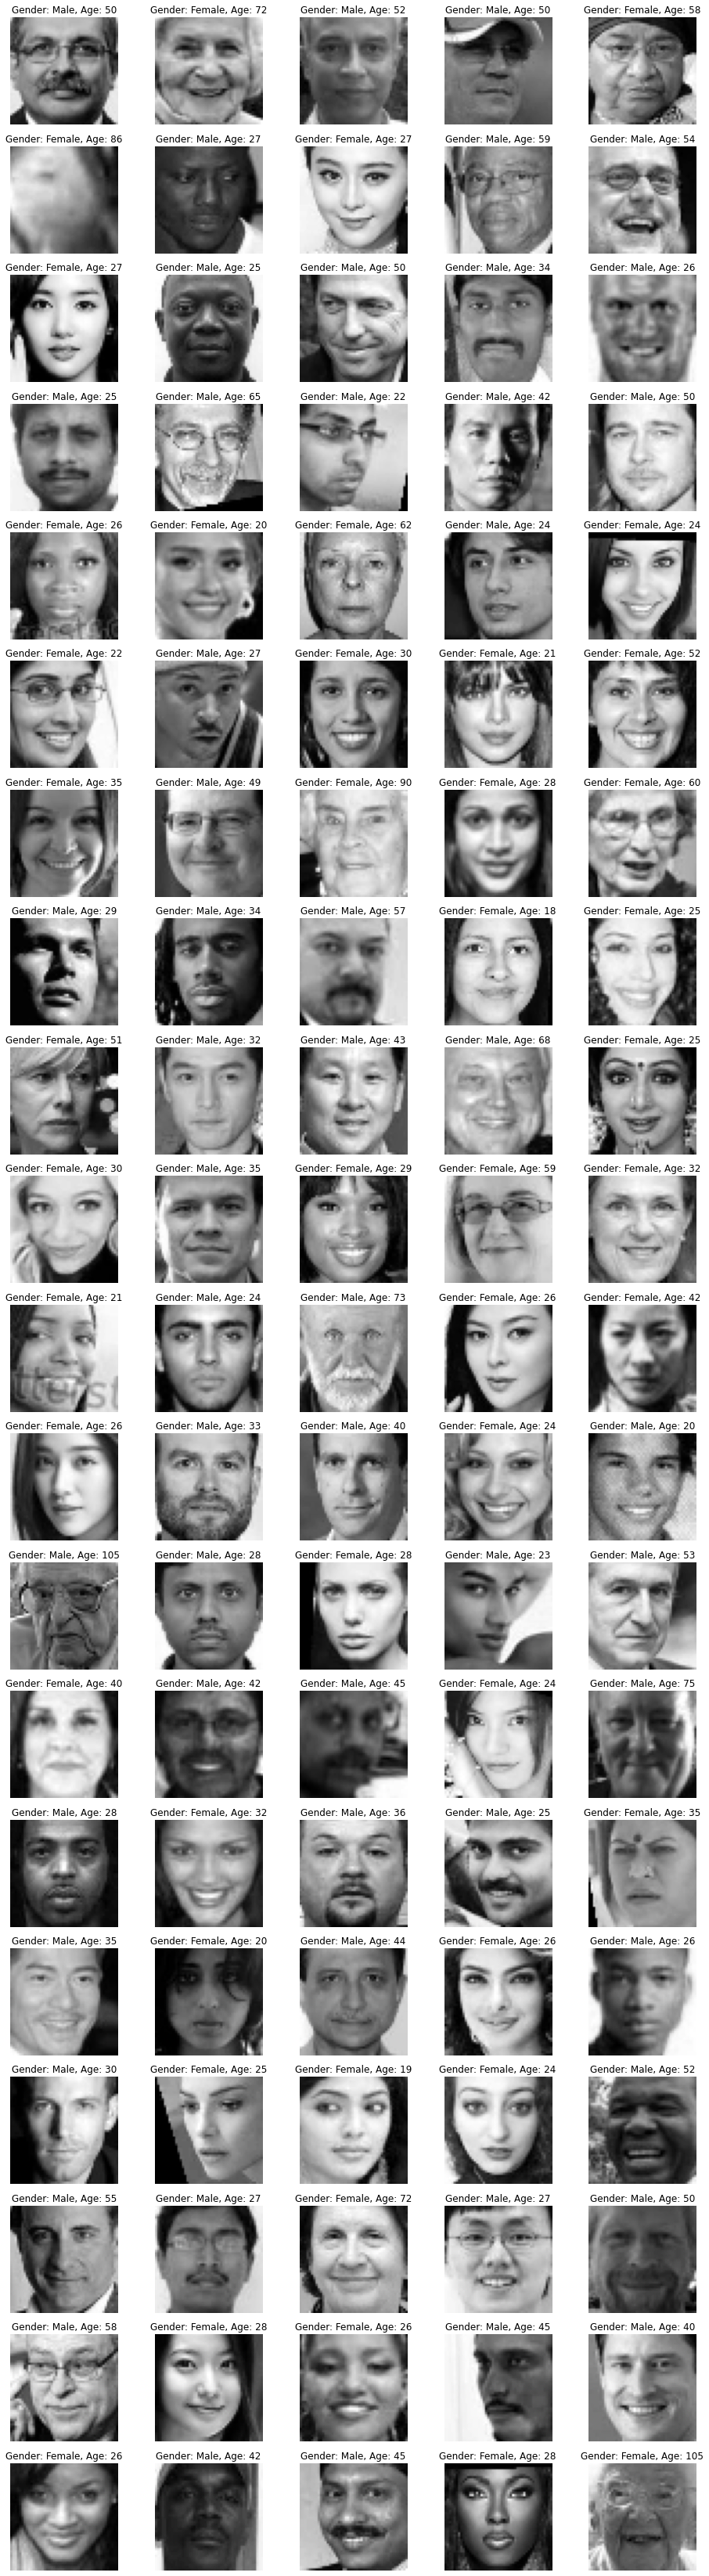

In [31]:
rows = 20 # rows in subplots
cols = 5 # columns in subplots
samp = random.sample(range(X.shape[0]),rows*cols) #selecting 100 random samples
x_samp = X[samp,:,:,:]
y_samp_gender = y_gender[samp]
y_samp_age = y_age[samp]
    
fig,ax = plt.subplots(rows,cols,figsize=(16,60))
r = 0
c = 0   

for i in range(rows*cols):
    aa = x_samp[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    ax[r,c].set_title(f"Gender: {'Female' if y_samp_gender[i]==1 else 'Male'}, Age: {y_samp_age[i]}")
    c+=1
    if c == cols:
        c=0
        r+=1
        
plt.show()

<h1>Image Augmentation</h1>

In [73]:
train_data_gen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=1,
                                    brightness_range=[0.8,1.2],
                                    zoom_range=[0.8,1.2],
                                    rescale=1/255
                                   )
val_data_gen = ImageDataGenerator(rescale=1/255)

test_data_gen = ImageDataGenerator(rescale=1/255)

In [34]:
tf.random.set_seed(11)
random.seed(11)
np.random.seed(11)

val_data = val_data_gen.flow(X_val,y_val,
                                   seed=11,shuffle=False)

test_data = test_data_gen.flow(X_test,y_test,
                                   seed=11,shuffle=False)

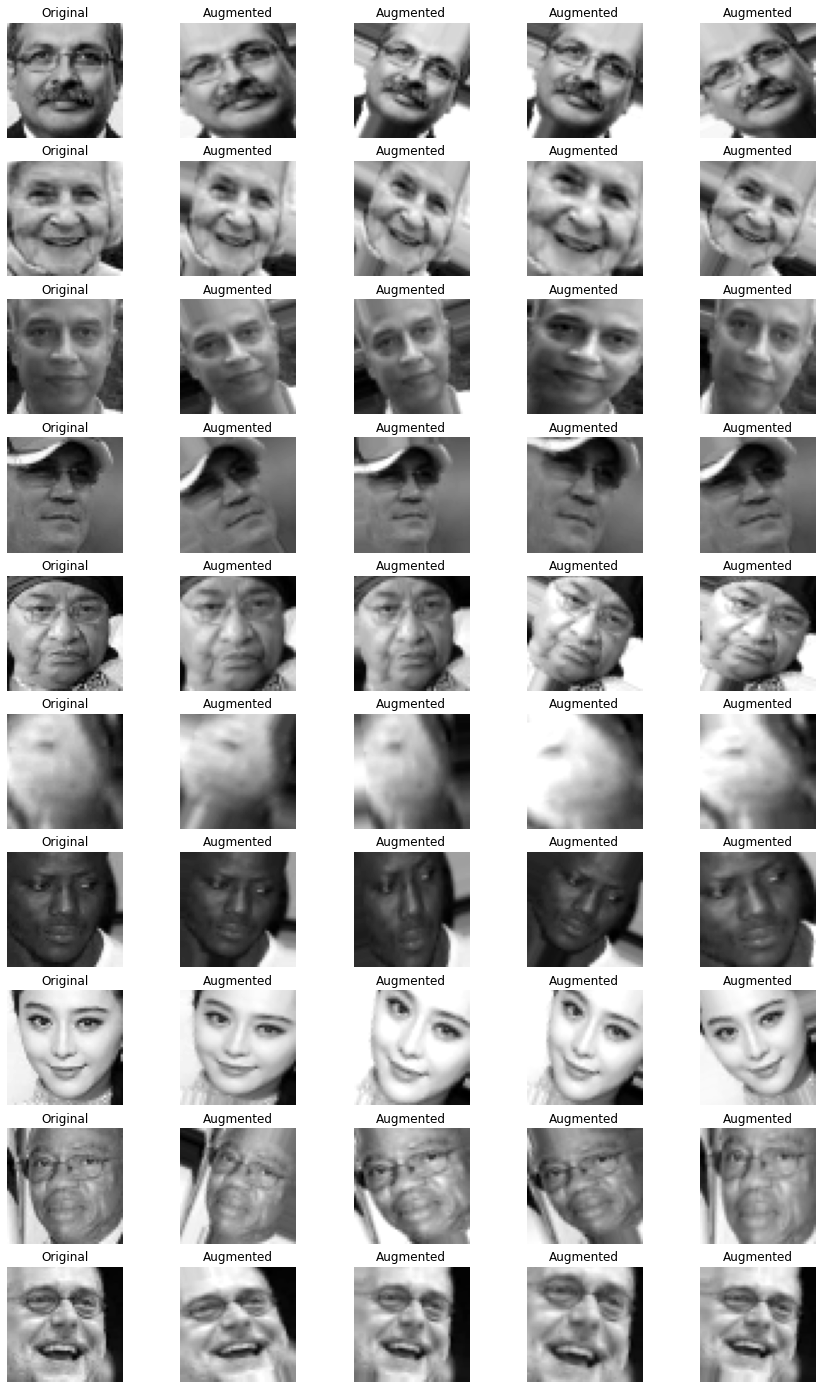

In [35]:
fig,ax = plt.subplots(10,5,figsize=(15,25))
for n in range(10):    
    r = random.sample(range(X.shape[0]),1)[0]
    ax[n,0].imshow(X[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

<h1>Training</h1>

In [57]:
# Model configuration
batch_size = 32
img_width, img_height, img_num_channels = 48, 48, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 10
optimizer = Adam()
verbosity = 1
num_folds = 2
activation='softmax'

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)
input_shape

(48, 48, 1)

In [58]:
# Set Seed
random.seed(11)
tf.random.set_seed(11)
np.random.seed(11)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [59]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y_gender):
    
  # Set Seed
  random.seed(11)
  tf.random.set_seed(11)
  np.random.seed(11)
  
  # Define the model architecture
  model = Sequential()
  
  model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  
  """
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  """
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
    
  early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min") # Ensure the model doesn't overfit
  
  # Set Seed
  random.seed(11)
  tf.random.set_seed(11)
  np.random.seed(11)
    
  # Fit data to model
  history = model.fit_generator(train_data_gen.flow(X[train], y_gender[train], seed=11),
            #callbacks=early_stop,
            steps_per_epoch=X[train].shape[0] // batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=train_data_gen.flow(X[test], y_gender[test],
                                   seed=11))
  
  # Generate generalization metrics
  fig = px.line(
  history.history, y=['loss', 'val_loss'],
  labels={'index': 'epoch', 'value': 'loss'}, 
  title='Training History')
  fig.show()
    
  scores = model.evaluate(train_data_gen.flow(X[test], y_gender[test],
                                   seed=11), verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 305 steps
Epoch 1/10
304/304 [==============================] - 57s 188ms/step - loss: 0.6029 - accuracy: 0.7607 - val_loss: 0.6333 - val_accuracy: 0.6139
Epoch 2/10
304/304 [==============================] - 56s 184ms/step - loss: 0.3911 - accuracy: 0.8264 - val_loss: 0.4789 - val_accuracy: 0.7766
Epoch 3/10
304/304 [==============================] - 56s 185ms/step - loss: 0.3532 - accuracy: 0.8482 - val_loss: 0.3679 - val_accuracy: 0.8432
Epoch 4/10
304/304 [==============================] - 56s 185ms/step - loss: 0.3256 - accuracy: 0.8613 - val_loss: 0.3557 - val_accuracy: 0.8440
Epoch 5/10
304/304 [==============================] - 58s 190ms/step - loss: 0.3105 - accuracy: 0.8673 - val_loss: 0.3742 - val_accuracy: 0.8471
Epoch 6/10
304/304 [==============================] - 56s 184ms/step - loss: 0.2924 

  ...
    to  
  ['...']
Score for fold 1: loss of 0.3050424645425843; accuracy of 87.57190108299255%
------------------------------------------------------------------------
Training for fold 2 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 305 steps
Epoch 1/10
304/304 [==============================] - 56s 185ms/step - loss: 0.6638 - accuracy: 0.7356 - val_loss: 0.6287 - val_accuracy: 0.6297
Epoch 2/10
304/304 [==============================] - 55s 182ms/step - loss: 0.4146 - accuracy: 0.8145 - val_loss: 0.4170 - val_accuracy: 0.8202
Epoch 3/10
304/304 [==============================] - 57s 188ms/step - loss: 0.3760 - accuracy: 0.8375 - val_loss: 0.3558 - val_accuracy: 0.8455
Epoch 4/10
304/304 [==============================] - 56s 184ms/step - loss: 0.3558 - accuracy: 0.8443 - val_loss: 0.3640 - val_accuracy: 0.8472
Epoch 5/10
304/304 [==============================] - 56s 183ms/step - loss: 0.3332 - accuracy: 0.8557 - val_loss: 0.3398 - val

  ...
    to  
  ['...']
Score for fold 2: loss of 0.3007290855050087; accuracy of 88.02382946014404%


In [60]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.3050424645425843 - Accuracy: 87.57190108299255%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.3007290855050087 - Accuracy: 88.02382946014404%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 87.7978652715683 (+- 0.22596418857574463)
> Loss: 0.30288577502379654
------------------------------------------------------------------------


In [62]:
"""Defining model again, this time for training it on the combined training and validation set."""

# Set Seed
random.seed(11)
tf.random.set_seed(11)
np.random.seed(11)
  
# Define the model architecture
model = Sequential()
  
model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

"""
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
"""

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='softmax'))

# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [66]:
Final_train = np.append(X_train, X_val, axis=0)
Final_val = np.append(y_train, y_val, axis=0)
final_training_data = train_data_gen.flow(Final_train, Final_val,
                                   seed=11)

random.seed(11)
tf.random.set_seed(11)
np.random.seed(11)
final_model_history = model.fit_generator(train_data_gen.flow(X, y_gender, seed=11),steps_per_epoch=Final_train.shape[0] // 32,epochs=20, validation_data=val_data)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 581 steps, validate for 156 steps
Epoch 1/20
581/581 [==============================] - 104s 178ms/step - loss: 0.5812 - accuracy: 0.7638 - val_loss: 0.4261 - val_accuracy: 0.8211
Epoch 2/20
581/581 [==============================] - 96s 166ms/step - loss: 0.3851 - accuracy: 0.8309 - val_loss: 0.3231 - val_accuracy: 0.8657
Epoch 3/20
581/581 [==============================] - 88s 152ms/step - loss: 0.3456 - accuracy: 0.8509 - val_loss: 0.5907 - val_accuracy: 0.8419
Epoch 4/20
581/581 [==============================] - 88s 152ms/step - loss: 0.3248 - accuracy: 0.8634 - val_loss: 0.2949 - val_accuracy: 0.8783
Epoch 5/20
581/581 [==============================] - 89s 153ms/step - loss: 0.3075 - accuracy: 0.8725 - val_loss: 0.2547 - val_accuracy: 0.8971
Epoch 6/20
581/581 [==============================] - 88s 152ms/step - loss: 0.2887 - accuracy: 0.8815 - val_loss: 0.2466 - val_accuracy: 0.9061
Epoch 7/20
581/581 [===============

In [67]:
# Generate generalization metrics
fig = px.line(
final_model_history.history, y=['loss', 'val_loss'],
labels={'index': 'epoch', 'value': 'val_loss'}, 
title='Training History')
fig.show()


# Generate generalization metrics
fig = px.line(
final_model_history.history, y=['accuracy', 'val_accuracy'],
labels={'index': 'epoch', 'value': 'accuracy'}, 
title='Training History')
fig.show()

In [68]:
pwd

'C:\\Users\\rezwa\\Documents'

In [69]:
model.save("backup")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: backup\assets


<h1>Testing</h1>

In [70]:
# Metrics
model.evaluate(test_data)

  ...
    to  
  ['...']
28/28 [==============================] - 1s 33ms/step - loss: 0.2371 - accuracy: 0.9099


[0.2371270970574447, 0.90992016]